## Project IMPACT Covid Cases by Zip Code in Chicago 5/13/2020

### Purpose is to develop an infographic from the data that will show specific Chicago areas where Covid cases are recorded

#### https://data.cityofchicago.org/Health-Human-Services/COVID-19-Cases-Tests-and-Deaths-by-ZIP-Code/yhhz-zm2v

#### Each row is a Week of COVID-19 Metrics for a ZIP Code

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import calendar
import datetime
import seaborn as sns
from osgeo import gdal, ogr, osr
from fiona.ogrext import Iterator, ItemsIterator, KeysIterator
import geopandas as gpd
from geopandas import GeoDataFrame
import descartes
from shapely.geometry import Point, Polygon

In [2]:
zip_map = gpd.read_file('https://data.cityofchicago.org/api/geospatial/gdcf-axmw?method=export&format=Shapefile')

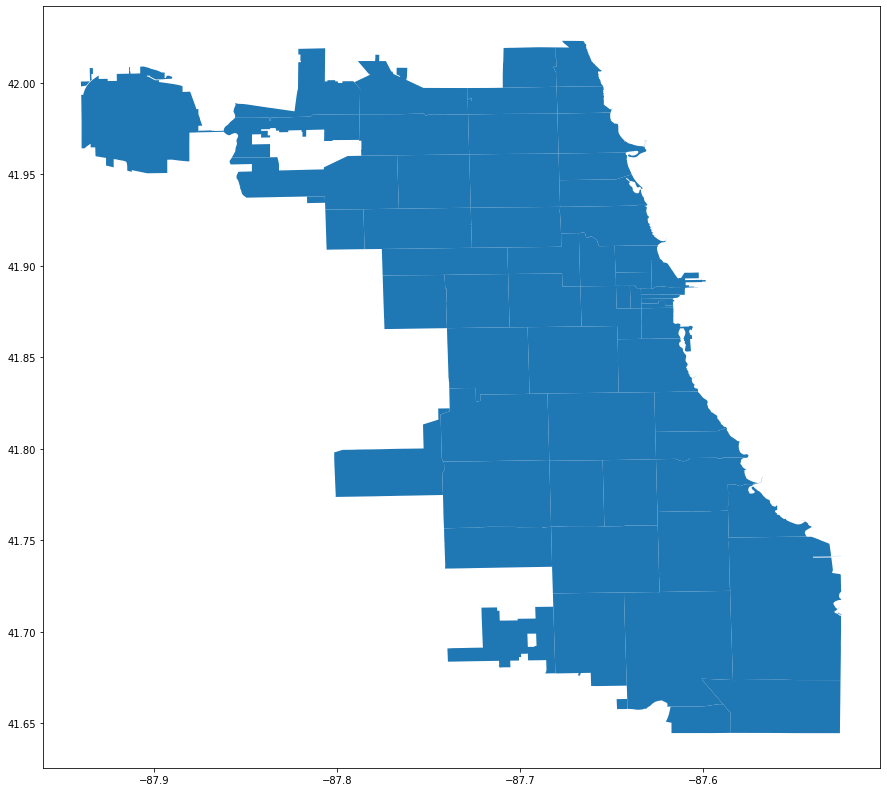

In [3]:
fig, ax = plt.subplots(figsize = (15,15))
zip_map.plot(ax=ax)

In [4]:
covid = pd.read_csv(('COVID-19_Cases__Tests__and_Deaths_by_ZIP_Code-5-13-20.csv'))

In [5]:
covid.head()

,ZIP Code,Week Number,Week Start,Week End,Cases - Weekly,Cases - Cumulative,Case Rate - Weekly,Case Rate - Cumulative,Tests - Weekly,Tests - Cumulative,...,Test Rate - Cumulative,Percent Tested Positive - Weekly,Percent Tested Positive - Cumulative,Deaths - Weekly,Deaths - Cumulative,Death Rate - Weekly,Death Rate - Cumulative,Population,Row ID,ZIP Code Location
0,60604,12,3/15/2020,3/21/2020,NaN,NaN,NaN,NaN,0,0,...,0,NaN,NaN,0,0,0.0,0.0,570,60604-12,POINT (-87.62902900000002 41.878153)
1,60621,11,3/8/2020,3/14/2020,NaN,NaN,NaN,NaN,3,3,...,8.4,NaN,NaN,0,0,0.0,0.0,"35,912",60621-11,POINT (-87.638812 41.776931)
2,60626,11,3/8/2020,3/14/2020,NaN,NaN,NaN,NaN,5,6,...,12,NaN,NaN,0,0,0.0,0.0,"50,139",60626-11,POINT (-87.669834 42.009469)
3,60606,19,5/3/2020,5/9/2020,7.0,36,303.0,"1,559.80",48,228,...,"9,878.70",0.1,0.2,0,1,0.0,43.3,"2,308",60606-19,POINT (-87.63676 41.882634)
4,60638,15,4/5/2020,4/11/2020,81.0,148,147.0,269,232,648,...,"1,177.60",0.3,0.2,2,3,3.6,5.5,"55,026",60638-15,POINT (-87.771902 41.787032)


In [6]:
#The missing values are due to data not available until there are >=5 cases, so replace the blanks with 0
covid.replace(np.nan, 0, inplace = True)

In [7]:
covid.head(1)

,ZIP Code,Week Number,Week Start,Week End,Cases - Weekly,Cases - Cumulative,Case Rate - Weekly,Case Rate - Cumulative,Tests - Weekly,Tests - Cumulative,...,Test Rate - Cumulative,Percent Tested Positive - Weekly,Percent Tested Positive - Cumulative,Deaths - Weekly,Deaths - Cumulative,Death Rate - Weekly,Death Rate - Cumulative,Population,Row ID,ZIP Code Location
0,60604,12,3/15/2020,3/21/2020,0.0,0,0.0,0,0,0,...,0,0.0,0.0,0,0,0.0,0.0,570,60604-12,POINT (-87.62902900000002 41.878153)


In [8]:
covid.dtypes

ZIP Code                                 object
Week Number                               int64
Week Start                               object
Week End                                 object
Cases - Weekly                          float64
Cases - Cumulative                       object
Case Rate - Weekly                      float64
Case Rate - Cumulative                   object
Tests - Weekly                           object
Tests - Cumulative                       object
Test Rate - Weekly                       object
Test Rate - Cumulative                   object
Percent Tested Positive - Weekly        float64
Percent Tested Positive - Cumulative    float64
Deaths - Weekly                           int64
Deaths - Cumulative                       int64
Death Rate - Weekly                     float64
Death Rate - Cumulative                 float64
Population                               object
Row ID                                   object
ZIP Code Location                       

In [9]:
#Convert the Cases - Weekly and Cases - Cumulative from float to integer format
covid["Cases - Weekly"] = covid["Cases - Weekly"].astype(int)



In [10]:
covid["Cases - Cumulative"] = covid["Cases - Cumulative"].fillna(0)
covid["Cases - Cumulative"] = covid["Cases - Cumulative"].str.replace(",",".")
covid["Cases - Cumulative"] = covid["Cases - Cumulative"].astype("float")
#From Thinkful technical coaching
#You were getting the error because the decimal separator in that field is comma (,). Use the following code:

In [11]:
covid["Cases - Cumulative"]
    

0        NaN
1        NaN
2        NaN
3       36.0
4      148.0
       ...  
595    232.0
596     71.0
597     67.0
598      9.0
599      NaN
Name: Cases - Cumulative, Length: 600, dtype: float64

In [12]:
covid["Cases - Cumulative"].replace(np.nan, 0, inplace = True)

In [13]:
covid["Cases - Cumulative"]= covid["Cases - Cumulative"].astype(int)

In [14]:
covid.head()

,ZIP Code,Week Number,Week Start,Week End,Cases - Weekly,Cases - Cumulative,Case Rate - Weekly,Case Rate - Cumulative,Tests - Weekly,Tests - Cumulative,...,Test Rate - Cumulative,Percent Tested Positive - Weekly,Percent Tested Positive - Cumulative,Deaths - Weekly,Deaths - Cumulative,Death Rate - Weekly,Death Rate - Cumulative,Population,Row ID,ZIP Code Location
0,60604,12,3/15/2020,3/21/2020,0,0,0.0,0,0,0,...,0,0.0,0.0,0,0,0.0,0.0,570,60604-12,POINT (-87.62902900000002 41.878153)
1,60621,11,3/8/2020,3/14/2020,0,0,0.0,0,3,3,...,8.4,0.0,0.0,0,0,0.0,0.0,"35,912",60621-11,POINT (-87.638812 41.776931)
2,60626,11,3/8/2020,3/14/2020,0,0,0.0,0,5,6,...,12,0.0,0.0,0,0,0.0,0.0,"50,139",60626-11,POINT (-87.669834 42.009469)
3,60606,19,5/3/2020,5/9/2020,7,36,303.0,"1,559.80",48,228,...,"9,878.70",0.1,0.2,0,1,0.0,43.3,"2,308",60606-19,POINT (-87.63676 41.882634)
4,60638,15,4/5/2020,4/11/2020,81,148,147.0,269,232,648,...,"1,177.60",0.3,0.2,2,3,3.6,5.5,"55,026",60638-15,POINT (-87.771902 41.787032)


In [15]:
#Group by the zip code and its specific week of the year (10-19) to see
#which zip code has the highest cumulative Covid cases (by week 18 or 19)
covid_zip_total_cases = covid.groupby(["Row ID"])["Cases - Cumulative"].sum().nlargest(10)

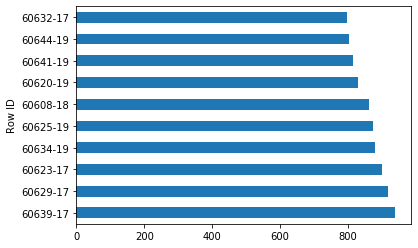

In [16]:
covid_zip_total_cases.plot.barh()

In [17]:
covid["ZIP Code Location"]

0      POINT (-87.62902900000002 41.878153)
1              POINT (-87.638812 41.776931)
2              POINT (-87.669834 42.009469)
3               POINT (-87.63676 41.882634)
4              POINT (-87.771902 41.787032)
                       ...                 
595            POINT (-87.611244 41.819261)
596            POINT (-87.701101 41.921058)
597            POINT (-87.771902 41.787032)
598            POINT (-87.717446 41.850321)
599              POINT (-87.63581 41.90455)
Name: ZIP Code Location, Length: 600, dtype: object

In [19]:
crs = {'init': 'epsg:4326'}

In [20]:
covid['geometry'] = covid["ZIP Code Location"]

In [21]:
covid.head(1)

,ZIP Code,Week Number,Week Start,Week End,Cases - Weekly,Cases - Cumulative,Case Rate - Weekly,Case Rate - Cumulative,Tests - Weekly,Tests - Cumulative,...,Percent Tested Positive - Weekly,Percent Tested Positive - Cumulative,Deaths - Weekly,Deaths - Cumulative,Death Rate - Weekly,Death Rate - Cumulative,Population,Row ID,ZIP Code Location,geometry
0,60604,12,3/15/2020,3/21/2020,0,0,0.0,0,0,0,...,0.0,0.0,0,0,0.0,0.0,570,60604-12,POINT (-87.62902900000002 41.878153),POINT (-87.62902900000002 41.878153)


In [30]:
covid.geometry

0      POINT (-87.62902900000002 41.878153)
1              POINT (-87.638812 41.776931)
2              POINT (-87.669834 42.009469)
3               POINT (-87.63676 41.882634)
4              POINT (-87.771902 41.787032)
                       ...                 
595            POINT (-87.611244 41.819261)
596            POINT (-87.701101 41.921058)
597            POINT (-87.771902 41.787032)
598            POINT (-87.717446 41.850321)
599              POINT (-87.63581 41.90455)
Name: geometry, Length: 600, dtype: object

In [31]:
from shapely import wkt

In [26]:
#geo_covid = gpd.GeoDataFrame(covid, crs = crs, geometry = covid.geometry)

In [61]:
covid = covid[covid.geometry != 0]

In [62]:
covid.geometry
#covid['geometry'] = covid['geometry'].apply(wkt.loads)
#gdf = gpd.GeoDataFrame(covid, geometry = 'geometry')

0      POINT (-87.62902900000002 41.878153)
1              POINT (-87.638812 41.776931)
2              POINT (-87.669834 42.009469)
3               POINT (-87.63676 41.882634)
4              POINT (-87.771902 41.787032)
                       ...                 
595            POINT (-87.611244 41.819261)
596            POINT (-87.701101 41.921058)
597            POINT (-87.771902 41.787032)
598            POINT (-87.717446 41.850321)
599              POINT (-87.63581 41.90455)
Name: geometry, Length: 590, dtype: object

In [64]:
covid['geometry'] = covid['geometry'].apply(wkt.loads)

C:\Users\ilang\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [69]:
gdf = gpd.GeoDataFrame(covid, crs = crs, geometry='geometry')


C:\Users\ilang\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [70]:
gdf.head(1)

,ZIP Code,Week Number,Week Start,Week End,Cases - Weekly,Cases - Cumulative,Case Rate - Weekly,Case Rate - Cumulative,Tests - Weekly,Tests - Cumulative,...,Percent Tested Positive - Weekly,Percent Tested Positive - Cumulative,Deaths - Weekly,Deaths - Cumulative,Death Rate - Weekly,Death Rate - Cumulative,Population,Row ID,ZIP Code Location,geometry
0,Unknown,12,3/15/2020,3/21/2020,0,0,0.0,0,0,0,...,0.0,0.0,0,0,0.0,0.0,570,60604-12,POINT (-87.62902900000002 41.878153),POINT (-87.62903 41.87815)


C:\Users\ilang\anaconda3\lib\site-packages\geopandas\plotting.py:532: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


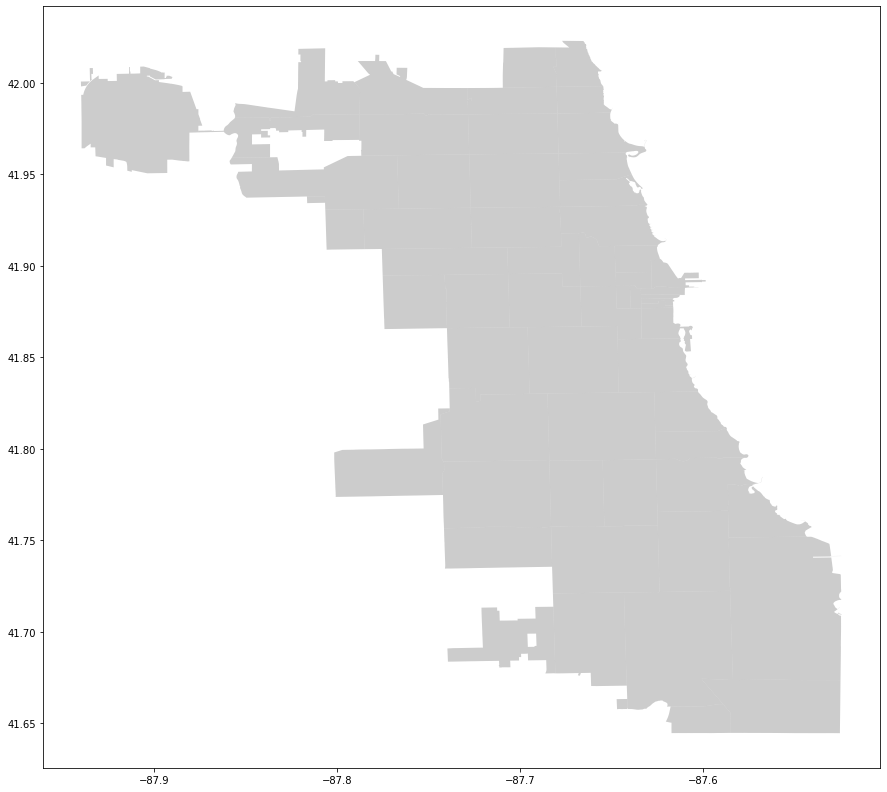

In [71]:
fig, ax = plt.subplots(figsize = (15,15))
zip_map.plot(ax=ax, alpha = 0.4, color = "grey")
gdf[gdf['Cases - Cumulative']>1000].plot(ax=ax, markersize=20, color = "blue", marker = "o", label="Case")

In [79]:
gdf.is_empty.value_counts()

False    590
dtype: int64

In [84]:
gdf.isna()/gdf.columns()

TypeError: 'Index' object is not callable

In [87]:
len(gdf.columns)

22